### Kalman fiilter in 1D

https://github.com/sharathsrini/Kalman-Filter-for-Sensor-Fusion/blob/master/Kalman_Filter.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
from scipy import stats
import time

In [3]:
np.random.seed(1214)

In [4]:
%matplotlib inline
fw = 10 # figure width

### Predict

Both Distributions have to be merged together
$\mu_\text{new}=\mu_\text{0}+\mu_\text{move}$ is the new mean and $\sigma^2_\text{new}=\sigma^2_\text{0}+\sigma^2_\text{move}$ is the new variance.



In [5]:
def predict(var, mean, varMove, meanMove):
    new_var = var + varMove
    new_mean= mean+ meanMove
    return new_var, new_mean

The more often you run the predict step, the flatter the distribution get

### Correct

Now both Distributions have to be merged together
$\sigma^2_\text{new}=\cfrac{1}{\cfrac{1}{\sigma^2_\text{old}}+\cfrac{1}{\sigma^2_\text{Sensor}}}$ is the new variance and the new mean value is $\mu_\text{new}=\cfrac{\sigma^2_\text{Sensor} \cdot \mu_\text{old} + \sigma^2_\text{old} \cdot \mu_\text{Sensor}}{\sigma^2_\text{old}+\sigma^2_\text{Sensor}}$

In [6]:
def correct(var, mean, varSensor, meanSensor):
    new_mean=(varSensor*mean + var*meanSensor) / (var+varSensor)
    new_var = 1/(1/var +1/varSensor)
    return new_var, new_mean

### First cycle : prediction + correction

In [7]:
x = np.linspace(-100,100,1000)

In [26]:
mean0 = 0.0   # e.g. meters or miles
var0  = 20.0# 50.0#20.0

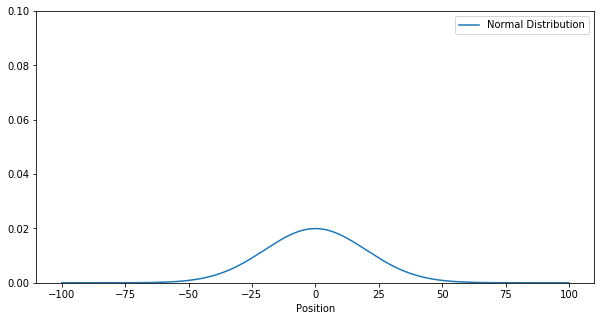

In [27]:
plt.figure(figsize=(fw,5))
plt.plot(x,mlab.normpdf(x, mean0, var0), label='Normal Distribution')
plt.ylim(0, 0.1);
plt.legend(loc='best');
plt.xlabel('Position');

Now we have something, which estimates the moved distance. VarMove is the estimated or determined with static measurements.

나는 한번에 이만큼 갈거 같음. (느낌으로)

In [10]:
meanMove = 25.0
varMove  = 10.0 

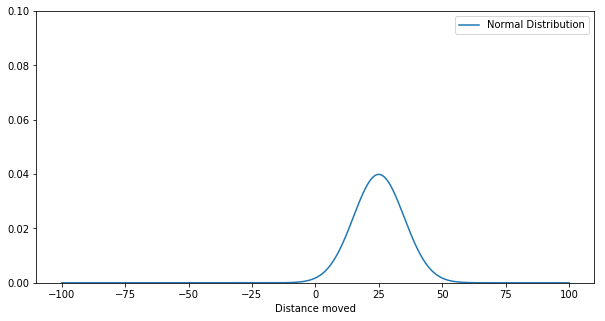

In [11]:
plt.figure(figsize=(fw,5))
plt.plot(x,mlab.normpdf(x, meanMove, varMove), label='Normal Distribution')
plt.ylim(0, 0.1);
plt.legend(loc='best');
plt.xlabel('Distance moved');

* First step : predict (느낌으로)

In [12]:
new_var, new_mean = predict(var0, mean0, varMove, meanMove)

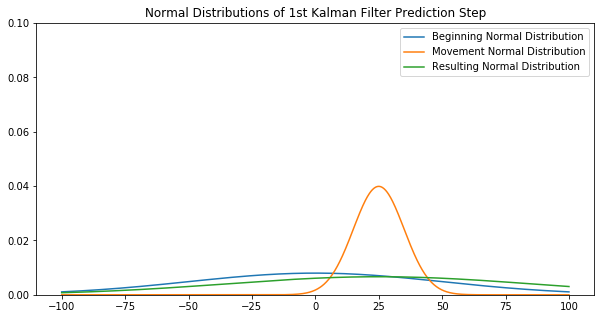

In [13]:
plt.figure(figsize=(fw,5))
plt.plot(x,mlab.normpdf(x, mean0, var0), label='Beginning Normal Distribution')
plt.plot(x,mlab.normpdf(x, meanMove, varMove), label='Movement Normal Distribution')
plt.plot(x,mlab.normpdf(x, new_mean, new_var), label='Resulting Normal Distribution')
plt.ylim(0, 0.1);
plt.legend(loc='best');
plt.title('Normal Distributions of 1st Kalman Filter Prediction Step');
plt.savefig('Kalman-Filter-1D-Step.png', dpi=150)

Prediction : Sensor없이 그냥 이쯤이면 이만큼 갈것이다라고 예측한 값

#### Sensor Defaults for Position Measurements
(Estimated or determined with static measurements)

In [14]:
meanSensor = 25.0
varSensor  = 12.0

In [15]:
var, mean = correct(new_var, new_mean, varSensor, meanSensor)

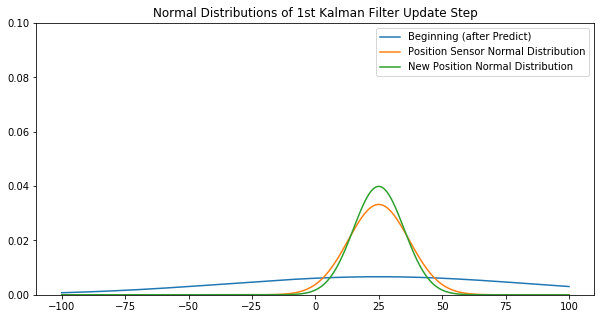

In [16]:
plt.figure(figsize=(fw,5))
plt.plot(x,mlab.normpdf(x, new_mean, new_var), label='Beginning (after Predict)')
plt.plot(x,mlab.normpdf(x, meanSensor, varSensor), label='Position Sensor Normal Distribution')
plt.plot(x,mlab.normpdf(x, mean, var), label='New Position Normal Distribution')
plt.ylim(0, 0.1);
plt.legend(loc='best');
plt.title('Normal Distributions of 1st Kalman Filter Update Step');

#### More cycles

Let's say, we have some measurements for position and for distance traveled. Both have to be fused with the 1D-Kalman Filter.

* Measurements

In [17]:
positions = (10, 20, 30, 40, 50)+np.random.randn(5) 

In [18]:
distances = (10, 10, 10, 10, 10)+np.random.randn(5)

In [19]:
positions

array([ 8.76480005, 18.95878458, 30.37963187, 40.69003491, 49.28458876])

In [20]:
distances

array([10.05014253,  9.43583392, 10.6584072 ,  9.02168786,  9.78325434])

In [21]:
vvar_p =[]
vvar_c = []

After correction:  mean= 18.62	var= 7.50
After correction:  mean= 22.66	var= 7.12
After correction:  mean= 31.59	var= 7.05
After correction:  mean= 40.66	var= 7.04
After correction:  mean= 49.76	var= 7.04


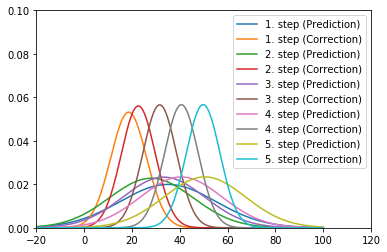

In [22]:
for m in range(len(positions)):
    
    # Predict
    var, mean = predict(var, mean, varMove, distances[m])
    #print('mean: %.2f\tvar:%.2f' % (mean, var))
    plt.plot(x, mlab.normpdf(x, mean, var), label='%i. step (Prediction)' % (m+1))
    
    vvar_p.append(var)
    
    # Correct
    var, mean = correct(var, mean, varSensor, positions[m])
    print('After correction:  mean= %.2f\tvar= %.2f' % (mean, var))
    plt.plot(x,mlab.normpdf(x, mean, var), label='%i. step (Correction)' % (m+1))
    
    vvar_c.append(var)
    
plt.ylim(0, 0.1);
plt.xlim(-20, 120)
plt.legend();

The sensors are represented as normal distributions with their parameters ($\mu$ and $\sigma^2$) and are calculated together with addition or convolution. The prediction decreases the certainty about the state, the correction increases the certainty.

Prediction: Certainty $\downarrow$
Correction: Certainty $\uparrow$

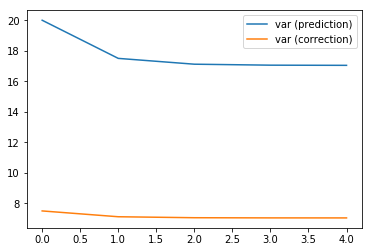

In [23]:
plt.plot(vvar_p, label='var (prediction)')
plt.plot(vvar_c, label='var (correction)')
plt.legend()

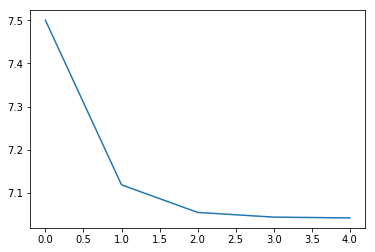

In [24]:
plt.plot(vvar_c)